Blast query elapsed time estmate.

In [1]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor,RandomForestRegressor
import xgboost

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

%matplotlib inline

In [2]:
# Load the Census dataset
data = pd.read_csv("data/data_00_12.csv")
data = data[data['dbid']!=0]
# Success - Display the first record
display(data.head(n=5))

,RID,f_ipv4,service_type,program,length_bp,dbid,dbsize_bp,started_at,run_time
2,TDGY7MGV014,-106884996,11,0,521,6154732,251782689291,Oct 4 2019 12:00:08:377AM,9
3,TDGY8SBB014,177491310,11,0,152,6154732,251782689291,Oct 4 2019 12:00:08:923AM,3
4,TDGY8J44014,789795757,2,2,250,93593,12472129,Oct 4 2019 12:00:08:847AM,2
5,TDGY8E4B014,789795757,1,2,250,3820422,85971353635,Oct 4 2019 12:00:08:940AM,23
7,TDGY9WHR014,-131182975,11,0,496,6154732,251782689291,Oct 4 2019 12:00:09:970AM,3


In [3]:
# Drop column that should not affect runtime of a query
subset = data.drop(['RID', 'f_ipv4', 'started_at'], axis=1)
display(subset.head(n=5))

,service_type,program,length_bp,dbid,dbsize_bp,run_time
2,11,0,521,6154732,251782689291,9
3,11,0,152,6154732,251782689291,3
4,2,2,250,93593,12472129,2
5,1,2,250,3820422,85971353635,23
7,11,0,496,6154732,251782689291,3


In [4]:
# Transform categorical features
categorical = ['service_type', 'program', 'dbid']
df = pd.get_dummies(pd.DataFrame(data = subset), columns=categorical)

# Apply log scale to run time
df[['run_time']] = df[['run_time']].apply(lambda x: np.log(x))
display(df.head(n=5))

,length_bp,dbsize_bp,run_time,service_type_1,service_type_2,service_type_5,service_type_6,service_type_7,service_type_8,service_type_11,...,dbid_6393552,dbid_6394482,dbid_6394492,dbid_6395552,dbid_6395702,dbid_6397782,dbid_6400712,dbid_6401272,dbid_6406612,dbid_6409862
2,521,251782689291,2.197225,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,152,251782689291,1.098612,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,250,12472129,0.693147,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,250,85971353635,3.135494,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,496,251782689291,1.098612,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Select target serices
run_time = df['run_time']
df = df.drop('run_time', axis = 1)

In [6]:
# Split the features and 'run_time' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df, 
                                                    run_time, 
                                                    test_size = 0.2, 
                                                    random_state = 12345)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 39336 samples.
Testing set has 9835 samples.


In [7]:
def r2_score(model, X, y):
    model.fit(X, y)
    return model.score(X, y)

In [8]:
def evaluate(model, X, y):
    score = cross_val_score(model, X, y, cv=10, scoring='neg_mean_squared_error')
    return score.mean()

In [9]:
# Establish a baseline
# Compute regressor MSE on train set using cross validation for different
# data set sizes: 1%, 10%, 100%
clf_A = AdaBoostRegressor(n_estimators=50, random_state=112233)
clf_B = RandomForestRegressor(n_estimators=50, random_state=112233)
clf_C = GradientBoostingRegressor(n_estimators=50, random_state=112233)

N = len(y_train)
samples_100 = N
samples_10 = int(0.1 * N + 0.5)
samples_1 = int(0.01 * N + 0.5)

size = {0: samples_1,
        1: samples_10,
        2: samples_100}

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = evaluate(clf, X_train[: samples], y_train[:samples])
        
for name, values in results.items():
    print("{}".format(name))
    for k, error in values.items():
        print("\tsamples={}\t\tMSE={}".format(size[k], error*-1))

AdaBoostRegressor
	samples=393		MSE=1.6164835878180788
	samples=3934		MSE=1.583882377805367
	samples=39336		MSE=1.7296908312828638
RandomForestRegressor
	samples=393		MSE=1.7266879262164927
	samples=3934		MSE=1.3316773815735863
	samples=39336		MSE=1.1638772322067044
GradientBoostingRegressor
	samples=393		MSE=1.3644140527935573
	samples=3934		MSE=1.2543505185932309
	samples=39336		MSE=1.2279173534245198


In [10]:
def search(model, param_grid, X, y):
    model = RandomizedSearchCV(estimator = model, 
                               n_iter=20, 
                               param_distributions = param_grid, 
                               scoring='r2', #'neg_mean_squared_error',
                               n_jobs=4,
                               iid=False, 
                               cv=5)
    model.fit(X, y)
    return model

In [11]:
# Pick learning rate
for lr in [0.1, 0.05, 0.02, 0.01]:
    model = GradientBoostingRegressor(learning_rate=lr)
    score = r2_score(model, X_train, y_train)
    print("lr={}\tscore={}".format(lr, score))

lr=0.1	score=0.5807369962109992
lr=0.05	score=0.5490710575749047
lr=0.02	score=0.47135898160384404
lr=0.01	score=0.3685406997850724


In [12]:
learn_rate = 0.1
for i in [100, 200, 300, 500, 700, 1000]:
    model = GradientBoostingRegressor(learning_rate=learn_rate, n_estimators=i)
    score = r2_score(model, X_train, y_train)
    print("estimators={}\tscore={}".format(i, score))

estimators=100	score=0.5807369962109992
estimators=200	score=0.5993516431765972
estimators=300	score=0.6079540212705585
estimators=500	score=0.6197001211929967
estimators=700	score=0.6268648596267593
estimators=1000	score=0.6356401958008054


In [13]:
# Pick max_depth and min_samples_split
param_test = {'max_depth':[x for x in range(3,21,2)], 'min_samples_split':[x for x in range(5,80,10)]}
model = search(GradientBoostingRegressor(learning_rate=0.1, 
                                         n_estimators=200, 
                                         subsample=0.8, 
                                         random_state=10),
                                         param_test, 
                                         X_train, 
                                         y_train)
print(model.best_estimator_)
print(model.best_params_)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=11, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=45, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=10, subsample=0.8, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
{'min_samples_split': 45, 'max_depth': 11}


In [14]:
# Evaluate model performance
max_depth=model.best_params_['max_depth']
min_samples_split = model.best_params_['min_samples_split']
model = GradientBoostingRegressor(learning_rate=0.1, 
                                         max_depth=max_depth,
                                         min_samples_split = min_samples_split,
                                         n_estimators=200, 
                                         subsample=0.8, 
                                         random_state=10)
model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print("Train data set score...{}".format(score))

Train data set score...0.6974594350677988


In [15]:
# Pick min_samples_leaf
param_test = {'min_samples_leaf': [x for x in range(3, 15, 2)]}
model = search(GradientBoostingRegressor(learning_rate=0.1, 
                                         max_depth=max_depth,
                                         min_samples_split=min_samples_split,
                                         n_estimators=200, 
                                         subsample=0.8, 
                                         random_state=10),
                                         param_test, 
                                         X_train, 
                                         y_train)
print(model.best_estimator_)
print(model.best_params_)

/home/akotliarov/anaconda3/envs/env3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=11, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=3,
             min_samples_split=45, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=10, subsample=0.8, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
{'min_samples_leaf': 3}


In [16]:
# Evaluate model performance
min_samples_leaf = model.best_params_['min_samples_leaf']
model = GradientBoostingRegressor(learning_rate=0.1, 
                                         max_depth=max_depth,
                                         min_samples_split = min_samples_split,
                                         min_samples_leaf = min_samples_leaf,
                                         n_estimators=200, 
                                         subsample=0.8, 
                                         random_state=10)
model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print("Train data set score...{}".format(score))

Train data set score...0.6948736455421783


In [17]:
# Final model.
model = GradientBoostingRegressor(learning_rate=0.1, 
                                         max_depth=max_depth,
                                         min_samples_split = min_samples_split,
                                         min_samples_leaf = min_samples_leaf,
                                         n_estimators=100, 
                                         subsample=0.7, 
                                         random_state=10)
model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print("Train data set score...{}".format(score))

Train data set score...0.6803676346884036


In [18]:
# Model's performance on test data.
score = model.score(X_test, y_test)
print("Test data set score...{}".format(score))
mse = mean_squared_error(y_test, model.predict(X_test))
print("MSE: %.4f" % mse)

Test data set score...0.6334491635695199
MSE: 0.9978


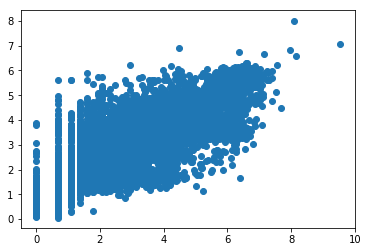

In [19]:
prediction = model.predict(X_test)
plt.scatter(y_test, prediction)

In [20]:
model = xgboost.XGBRegressor(objective="reg:squarederror", 
                             subsample=0.7,
                             learning_rate=0.1,
                             min_samples_leaf = min_samples_leaf,
                             min_samples_split=min_samples_split,
                             max_depth=max_depth, 
                             n_estimators=100)
model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print("Train data set score...R2={}, MSE={}".format(score, mean_squared_error(y_train, model.predict(X_train))))
score = model.score(X_test, y_test)
print("Test data set score...R2={}, MSE={}".format(score, mean_squared_error(y_test, model.predict(X_test))))


/home/akotliarov/anaconda3/envs/env3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Train data set score...R2=0.6961857404075824, MSE=0.8238306490632328
Test data set score...R2=0.629518581922832, MSE=1.0085186802492707


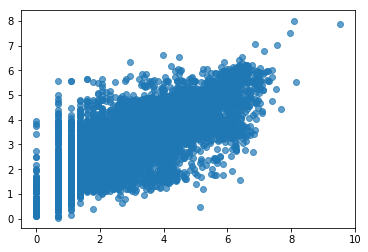

In [21]:
prediction = model.predict(X_test)
plt.scatter(y_test, prediction, alpha=0.7)